In [1]:
from pathlib import Path
from typing import Dict, List, Optional, Union
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision import utils as vutils
import torch.nn.functional as F
import torch.optim as optim
import ssl
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
ssl._create_default_https_context = ssl._create_unverified_context
torch.manual_seed(12)
torch.backends.cudnn.deterministic = True

torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 0 NVIDIA GeForce RTX 4090


In [2]:
transform=transforms.Compose([transforms.Resize(64),transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'fake')

100%|██████████| 170498071/170498071 [00:44<00:00, 3811883.37it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
print(trainloader.dataset[0][0].shape)

torch.Size([3, 64, 64])


torch.Size([64, 3, 64, 64])


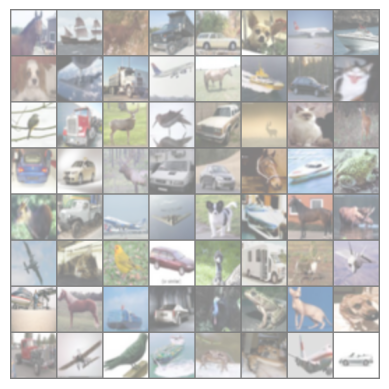

In [4]:
def showImage(images, epoch=-1):
    # 检查张量是否在 GPU 上
    if images.is_cuda:
        images = images.cpu()
    images = images.numpy()
    images = images/2 + 0.5
    plt.imshow(np.transpose(images, axes=(1, 2, 0)))

    plt.axis('off')
    if epoch!=-1:
        plt.savefig(str(epoch)+"-2" + ".png")

dataiter = iter(trainloader)
images,labels = next(dataiter)
print(images.size())
showImage(make_grid(images[0:64]))

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [6]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator,self).__init__()
        
        #input 100*1*1
        self.layer1 = nn.Sequential(nn.ConvTranspose2d(100,512,4,1,0,bias = False),nn.ReLU(True)) #input output kernel stride padding
        #input 512*4*4
        self.layer2 = nn.Sequential(nn.ConvTranspose2d(512,256,4,2,1,bias = False),nn.BatchNorm2d(256),nn.ReLU(True))
        #input 256*8*8
        self.layer3 = nn.Sequential(nn.ConvTranspose2d(256,128,4,2,1,bias = False),nn.BatchNorm2d(128),nn.ReLU(True))
        #input 128*16*16
        self.layer4 = nn.Sequential(nn.ConvTranspose2d(128,64,4,2,1,bias = False),nn.BatchNorm2d(64),nn.ReLU(True))
        #input 64*32*32
        self.layer5 = nn.Sequential(nn.ConvTranspose2d(64,3,4,2,1,bias = False),nn.Tanh())
        #output 3*64*64
      
        self.embedding = nn.Embedding(10,100)  #10 classes
        
        
    def forward(self,noise,label):
        
        label_embedding = self.embedding(label)
        x = torch.mul(noise,label_embedding)
        x = x.view(-1,100,1,1)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x
        

class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator,self).__init__()        
        
        #input 3*64*64
        self.layer1 = nn.Sequential(nn.Conv2d(3,64,4,2,1,bias = False),nn.BatchNorm2d(64),nn.LeakyReLU(0.2,True),nn.Dropout2d(0.5))
        #input 64*32*32
        self.layer2 = nn.Sequential(nn.Conv2d(64,128,4,2,1,bias = False),nn.BatchNorm2d(128),nn.LeakyReLU(0.2,True),nn.Dropout2d(0.5))
        #input 128*16*16
        self.layer3 = nn.Sequential(nn.Conv2d(128,256,4,2,1,bias = False),nn.BatchNorm2d(256),nn.LeakyReLU(0.2,True),nn.Dropout2d(0.5))
        #input 256*8*8
        self.layer4 = nn.Sequential(nn.Conv2d(256,512,4,2,1,bias = False),nn.BatchNorm2d(512),nn.LeakyReLU(0.2,True))
        #input 512*4*4
        self.validity_layer = nn.Sequential(nn.Conv2d(512,1,4,1,0,bias = False),nn.Sigmoid())
        
        self.label_layer = nn.Sequential(nn.Conv2d(512,11,4,1,0,bias = False),nn.LogSoftmax(dim = 1))   #one is 'fake' so 11 classes
        
    def forward(self,x):
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        validity = self.validity_layer(x)
        plabel = self.label_layer(x)
        
        validity = validity.view(-1)
        plabel = plabel.view(-1,11)
        
        return validity,plabel

[1/400]  G_loss: [3.4806] D_loss: [4.7033] 
[2/400]  G_loss: [7.0727] D_loss: [3.6959] 
[3/400]  G_loss: [6.5483] D_loss: [4.5314] 
[4/400]  G_loss: [2.4502] D_loss: [4.1466] 
[5/400]  G_loss: [1.4863] D_loss: [4.8955] 
[6/400]  G_loss: [3.4039] D_loss: [5.8108] 
[7/400]  G_loss: [3.3349] D_loss: [3.8267] 
[8/400]  G_loss: [1.9188] D_loss: [3.5376] 
[9/400]  G_loss: [3.0365] D_loss: [2.1521] 
[10/400]  G_loss: [3.6566] D_loss: [4.0404] 
[11/400]  G_loss: [3.1521] D_loss: [3.4227] 
[12/400]  G_loss: [2.0624] D_loss: [4.7263] 
[13/400]  G_loss: [2.8953] D_loss: [2.8790] 
[14/400]  G_loss: [2.2803] D_loss: [4.1760] 
[15/400]  G_loss: [15.3943] D_loss: [2.5963] 
[16/400]  G_loss: [6.5290] D_loss: [1.6647] 
[17/400]  G_loss: [3.7132] D_loss: [1.6465] 
[18/400]  G_loss: [0.9947] D_loss: [5.3398] 
[19/400]  G_loss: [11.1855] D_loss: [5.1805] 
[20/400]  G_loss: [1.2010] D_loss: [1.3322] 
[21/400]  G_loss: [10.8193] D_loss: [4.1442] 
[22/400]  G_loss: [3.9664] D_loss: [1.2120] 
[23/400]  G_loss

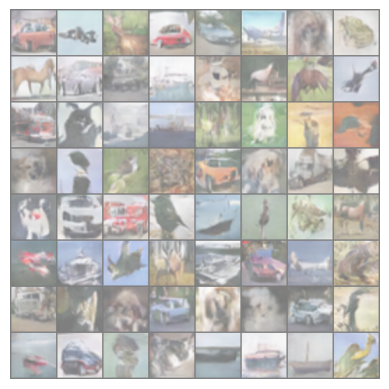

In [7]:
# init
gen = Generator().to(device)
gen.apply(weights_init)
disc = Discriminator().to(device)
disc.apply(weights_init)
    
# optim
optimG = optim.Adam(gen.parameters(), 0.0001, betas = (0.5,0.999))
optimD = optim.Adam(disc.parameters(), 0.0001, betas = (0.5,0.999))
validity_loss = nn.BCELoss()

# save image
def save_img(epoch):
    noise = torch.randn(64, 100, device=device) 
    sample_labels = torch.randint(0, 10, (64,), device=device, dtype=torch.long)

    # 使用generator生成假圖
    fake_images = gen(noise, sample_labels)
    fake_images_cpu = fake_images.cpu()

    showImage(make_grid(fake_images_cpu),epoch)

real_labels = 0.7 + 0.5 * torch.rand(10, device = device)
fake_labels = 0.3 * torch.rand(10, device = device)

d_loss_record=[]
g_loss_record=[]

epochs = 400
for epoch in range(1,epochs+1):
    
    for idx, (images,labels) in enumerate(trainloader,0):
        
        batch_size = images.size(0)
        labels= labels.to(device)
        images = images.to(device)
        
        real_label = real_labels[idx % 10] #real為1 fake為0，更改label數值和特並次數交換label來平滑化
        fake_label = fake_labels[idx % 10]
        
        fake_class_labels = 10*torch.ones((batch_size,),dtype = torch.long,device = device)
        
        if idx % 25 == 0:
            real_label, fake_label = fake_label, real_label
        

        # disc
        optimD.zero_grad()       
        validity_label = torch.full((batch_size,),real_label , device = device) # real
        pvalidity, plabels = disc(images)       
        errD_real_val = validity_loss(pvalidity, validity_label)            
        errD_real_label = F.nll_loss(plabels,labels)
        errD_real = errD_real_val + errD_real_label
        errD_real.backward()
        D_x = pvalidity.mean().item()        
        
        
        noise = torch.randn(batch_size,100,device = device) #fake 
        sample_labels = torch.randint(0,10,(batch_size,),device = device, dtype = torch.long)
        fakes = gen(noise,sample_labels)
        validity_label.fill_(fake_label)
        pvalidity, plabels = disc(fakes.detach())       
        errD_fake_val = validity_loss(pvalidity, validity_label)
        errD_fake_label = F.nll_loss(plabels, fake_class_labels)
        errD_fake = errD_fake_val + errD_fake_label
        errD_fake.backward()
        D_G_z1 = pvalidity.mean().item()
        errD = errD_real + errD_fake
        optimD.step()
    
        
        # gen
        optimG.zero_grad()
        noise = torch.randn(batch_size,100,device = device)  
        sample_labels = torch.randint(0,10,(batch_size,),device = device, dtype = torch.long)
        validity_label.fill_(1)
        fakes = gen(noise,sample_labels)
        pvalidity,plabels = disc(fakes)
        errG_val = validity_loss(pvalidity, validity_label)        
        errG_label = F.nll_loss(plabels, sample_labels)
        errG = errG_val + errG_label
        errG.backward()
        D_G_z2 = pvalidity.mean().item()
        optimG.step()

    if epoch%50==0:
        save_img(epoch)
        
    print("[{}/{}]  G_loss: [{:.4f}] D_loss: [{:.4f}] ".format(epoch,epochs,errG,errD))
    g_loss_record.append(errG)
    d_loss_record.append(errD)
    
torch.save(gen.state_dict(), 'Generator_weights.pth')
torch.save(disc.state_dict(), 'Discriminator_weights.pth')


In [10]:

d_loss_record = [loss.item() for loss in d_loss_record]
g_loss_record = [loss.item() for loss in g_loss_record]

print(d_loss_record)

[4.70329475402832, 3.6958699226379395, 4.531396865844727, 4.146638870239258, 4.895462512969971, 5.8107686042785645, 3.8267416954040527, 3.5376243591308594, 2.1520893573760986, 4.040361404418945, 3.4226646423339844, 4.726298809051514, 2.879007339477539, 4.176028251647949, 2.596316337585449, 1.6646592617034912, 1.646545171737671, 5.339781284332275, 5.180542945861816, 1.3322312831878662, 4.144223213195801, 1.2120264768600464, 2.3924689292907715, 1.400686502456665, 3.1863796710968018, 3.7464983463287354, 6.644881248474121, 3.2719826698303223, 2.6233768463134766, 2.372124195098877, 4.046106338500977, 6.505046367645264, 2.371645212173462, 2.011913299560547, 2.55469012260437, 4.911039352416992, 2.107475996017456, 2.0894086360931396, 2.6106629371643066, 2.397177219390869, 3.17763352394104, 2.265681266784668, 1.2425538301467896, 2.0860049724578857, 3.150904655456543, 3.8372652530670166, 1.847381830215454, 1.6943137645721436, 2.4230339527130127, 2.947704315185547, 3.311540126800537, 4.6859898567

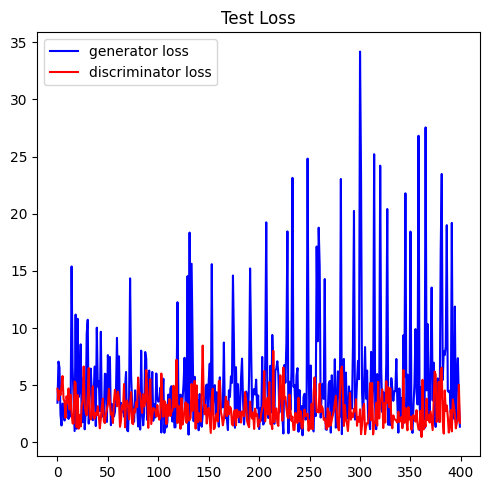

In [11]:
plt.figure(figsize=(5, 5))


plt.plot(g_loss_record, 'b', label='generator loss')
plt.title('Train Loss')
plt.legend()

plt.plot(d_loss_record, 'r', label='discriminator loss')
plt.title('Test Loss')
plt.legend()

plt.tight_layout()  # Ensures that the subplots do not overlap
plt.show()

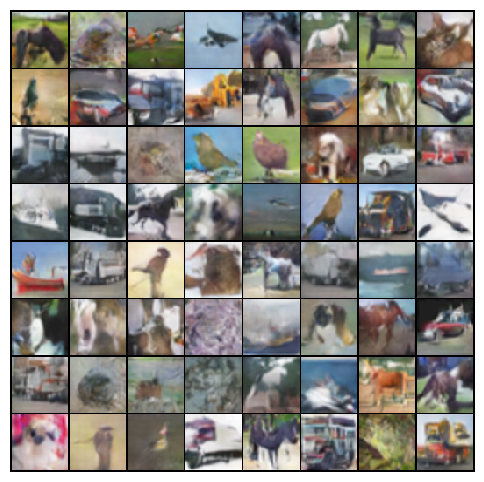

In [55]:
noise = torch.randn(64, 100, device=device) 
sample_labels = torch.randint(0, 10, (64,), device=device, dtype=torch.long)

# 使用生成器生成假图像
fake_images = gen(noise, sample_labels)
fake_images_cpu = fake_images.cpu()

grid_image = make_grid(fake_images_cpu, nrow=8, padding=2, normalize=True)

plt.figure(figsize=(6, 6))
plt.imshow(grid_image.permute(1, 2, 0), interpolation='nearest', aspect='auto')
plt.axis('off')  
plt.show()